In [42]:
# spectrogram

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
import matplotlib.pyplot as plt
import numpy as np
import librosa
import cv2
from IPython.display import display, Audio

In [44]:
import math
def init_kernel(frame_len,
                frame_hop,
                num_fft=None,
                window="sqrt_hann"):
    if window != "sqrt_hann":
        raise RuntimeError("Now only support sqrt hanning window in order "
                           "to make signal perfectly reconstructed")
    # FFT点数
    if not num_fft:
        # FFT points
        fft_size = 2 ** math.ceil(math.log2(frame_len))
    else:
        fft_size = num_fft
    # window [window_length]
    # 窗函数
    window = torch.hann_window(frame_len) ** 0.5
    S_ = 0.5 * (fft_size * fft_size / frame_hop) ** 0.5
    # window_length, F, 2 (real+imag)
    kernel = torch.rfft(torch.eye(fft_size) / S_, 1)[:frame_len]
    # 2, F, window_length
    kernel = torch.transpose(kernel, 0, 2) * window
    # 2F, 1, window_length
    kernel = torch.reshape(kernel, (fft_size + 2, 1, frame_len))
    return kernel

class STFTBase(nn.Module):
    """
    Base layer for (i)STFT
    NOTE:
        1) Recommend sqrt_hann window with 2**N frame length, because it
           could achieve perfect reconstruction after overlap-add
        2) Now haven't consider padding problems yet
    """

    def __init__(self,
                 frame_len,
                 frame_hop,
                 window="sqrt_hann",
                 num_fft=None):
        super(STFTBase, self).__init__()
        K = init_kernel(
            frame_len,
            frame_hop,
            num_fft=num_fft,
            window=window)
        self.K = nn.Parameter(K, requires_grad=False)
        self.stride = frame_hop
        self.window = window

    def freeze(self):
        self.K.requires_grad = False

    def unfreeze(self):
        self.K.requires_grad = True

    def check_nan(self):
        num_nan = torch.sum(torch.isnan(self.K))
        if num_nan:
            raise RuntimeError(
                "detect nan in STFT kernels: {:d}".format(num_nan))
            
class STFT(STFTBase):
    """
    Short-time Fourier Transform as a Layer
    """

    def __init__(self, *args, **kwargs):
        super(STFT, self).__init__(*args, **kwargs)

    def forward(self, x):
        """
        Accept raw waveform and output magnitude and phase
        x: input signal, N x 1 x S or N x S
        m: magnitude, N x F x T
        p: phase, N x F x T
        """
        if x.dim() not in [2, 3]:
            raise RuntimeError("Expect 2D/3D tensor, but got {:d}D".format(
                x.dim()))
        self.check_nan()
        # if N x S, reshape N x 1 x S
        if x.dim() == 2:
            x = torch.unsqueeze(x, 1)
        # N x 2F x T
        c = F.conv1d(x, self.K, stride=self.stride, padding=0)
        # N x F x T
        r, i = torch.chunk(c, 2, dim=1)
        m = (r ** 2 + i ** 2) ** 0.5
        p = torch.atan2(i, r)
        return m, p

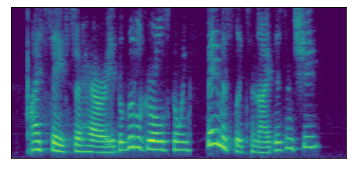

In [45]:
stft = STFT(512, 128)
plt.rcParams['figure.figsize'] = (6,6)

wav, fs = ta.load('/home/jiangji/basic/codebase/demo-confusion/wavs/4446-2271-0012_1580-141083-0012_e0.wav')
mag, pha = stft(wav)
mag = mag.detach().cpu().numpy().squeeze()
y = librosa.amplitude_to_db(np.abs(mag), ref=np.max)

y = cv2.resize(y, (y.shape[0]*2, y.shape[1]), interpolation=cv2.INTER_AREA) 
plt.xticks([])
plt.yticks([])
plt.imshow(np.flip(y,axis=0))
plt.show()

In [5]:
# sample selection

In [6]:
import pandas as pd
import os

In [7]:
bsln_path = '/home/jiangji/basic/exp-ct/bsln_base100/eval'
proposed_path = '/home/jiangji/basic/exp-ct/RTO-3/pnlSOTA_RTO-31/test'
enroll_csv_path = '/home/jiangji/basic/dataset/libri2mix-informed/wav8k/min/test/mixture2enrollment.csv'

In [8]:
csv_bsln = pd.read_csv(os.path.join(bsln_path, 'all_metrics.csv'))
csv_proposed = pd.read_csv(os.path.join(proposed_path, 'all_metrics.csv'))
csv_enroll = pd.read_csv(enroll_csv_path)
wav_bsln = os.path.join(bsln_path, 'wav_est/')
wav_proposed = os.path.join(proposed_path, 'wav_est/')

In [16]:
# Copyright (c) 2021 Brno University of Technology
# Copyright (c) 2021 Nippon Telegraph and Telephone corporation (NTT).
# All rights reserved
# By Katerina Zmolikova, August 2021.

from pathlib import Path
from collections import defaultdict
import numpy as np
from torch.utils.data import Dataset
from asteroid.data import LibriMix # asteroid/data/librimix_dataset.py
import random
import torch
import soundfile as sf

def read_enrollment_csv(csv_path):
    data = defaultdict(dict)
    with open(csv_path, 'r') as f:
        f.readline() # csv header

        for line in f:
            mix_id, utt_id, *aux = line.strip().split(',')
            aux_it = iter(aux)
            aux = [(auxpath,int(float(length))) for auxpath, length in zip(aux_it, aux_it)]
            data[mix_id][utt_id] = aux
    return data

class LibriMixInformed(Dataset):
    def __init__(
        self, csv_dir, task="sep_clean", sample_rate=16000, n_src=2, 
        segment=3, segment_aux=3, debug=False, 
        ):
        print('  >> 读取Libri2Mix...')
        self.base_dataset = LibriMix(csv_dir, task, sample_rate, n_src, segment)
        print('  >> 读取enrollment csv...')
        self.data_aux = read_enrollment_csv(Path(csv_dir) / 'mixture2enrollment.csv')

        if segment_aux is not None:
            max_len = np.sum([len(self.data_aux[m][u]) for m in self.data_aux 
                                                     for u in self.data_aux[m]])
            self.seg_len_aux = int(segment_aux * sample_rate)
            self.data_aux = {m: {u:  
                [(path,length) for path, length in self.data_aux[m][u]
                    if length >= self.seg_len_aux
                    ]
                for u in self.data_aux[m]} for m in self.data_aux}
            new_len = np.sum([len(self.data_aux[m][u]) for m in self.data_aux 
                                                     for u in self.data_aux[m]])
            print(
                f"Drop {max_len - new_len} utterances from {max_len} "
                f"(shorter than {segment_aux} seconds)"
            )
        else:
            self.seg_len_aux = None

        self.seg_len = self.base_dataset.seg_len

        # to choose pair of mixture and target speaker by index
        self.data_aux_list = [(m,u) for m in self.data_aux 
                                    for u in self.data_aux[m]]
        
        self.debug = debug

    def __len__(self):
        #return len(self.data_aux_list)
        if self.debug:
            return len(self.data_aux_list) // 20
        else:
            return len(self.data_aux_list)

    def _get_segment_start_stop(self, seg_len, length):
        if seg_len is not None:
            start = random.randint(0, length - seg_len)
            stop = start + seg_len
        else:
            start = 0
            stop = None
        return start, stop

    def __getitem__(self, idx):
        mix_id, utt_id = self.data_aux_list[idx]
        row = self.base_dataset.df[self.base_dataset.df['mixture_ID'] == mix_id].squeeze()

        mixture_path = row['mixture_path']
        self.mixture_path = mixture_path
        tgt_spk_idx = mix_id.split('_').index(utt_id)
        self.target_speaker_idx = tgt_spk_idx

        # read mixture
        start, stop = self._get_segment_start_stop(self.seg_len, row['length'])
        mixture,_ = sf.read(mixture_path, dtype="float32", start=start, stop=stop)
        mixture = torch.from_numpy(mixture)

        # read source
        source_path = row[f'source_{tgt_spk_idx+1}_path']
        source,_ = sf.read(source_path, dtype="float32", start=start, stop=stop)
        source = torch.from_numpy(source)[None]

        # read enrollment
        enroll_path, enroll_length = random.choice(self.data_aux[mix_id][utt_id])
        start_e, stop_e = self._get_segment_start_stop(self.seg_len_aux, enroll_length)
        enroll,_ = sf.read(enroll_path, dtype="float32", start=start_e, stop=stop_e)
        enroll = torch.from_numpy(enroll)

        #      (len,) (1, len,) (len, ), len=segment*sample_rate
        return mixture, source, enroll, source_path, enroll_path

    def get_infos(self):
        return self.base_dataset.get_infos()

  >> 读取Libri2Mix...
  >> 读取enrollment csv...
-7.79 13.7
2830-3980-0071_5142-33396-0024
/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/2830-3980-0071_5142-33396-0024.wav
/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/4970-29095-0038_5142-33396-0003.wav


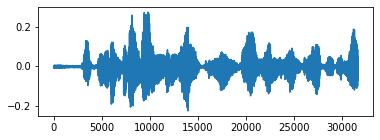

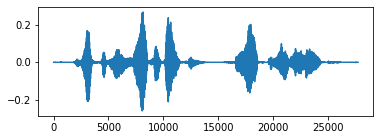

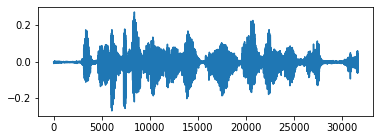

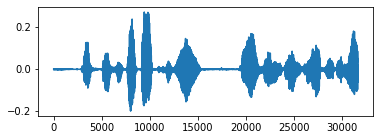

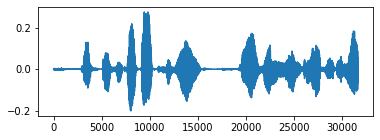

In [59]:
test_set = LibriMixInformed(
        csv_dir="/home/jiangji/basic/dataset/libri2mix-informed/wav8k/min/test",
        task="sep_clean",
        sample_rate=8000,
        n_src=2,
        segment=None,
        segment_aux=None,
    )

plt.rcParams['figure.figsize'] = (6,2)
for idx in range(len(csv_bsln)):
    sisdri_bsln = np.round(csv_bsln['si_sdr'][idx] - csv_bsln['input_si_sdr'][idx], 2)
    sisdri_proposed = np.round(csv_proposed['si_sdr'][idx] - csv_bsln['input_si_sdr'][idx], 2)
    
    if sisdri_bsln < -5 and sisdri_proposed >= 10 and csv_proposed['si_sdr'][idx] >= 10:
        
        filename = csv_bsln['mix_path'][idx].split('/')[-1]
        mix_id = filename.split('.')[0]
        
        spk = 0 if idx%2==0 else 1
        est_bsln_path = os.path.join(wav_bsln, mix_id+f'_s{spk}.wav')
        est_proposed_path = os.path.join(wav_proposed, mix_id+f'_s{spk}.wav')
        
        mix, s, e, s_path, enroll_path = test_set[idx]
        bsln, fs = ta.load(est_bsln_path)
        proposed, fs = ta.load(est_proposed_path)

        print(sisdri_bsln, sisdri_proposed)
        print(mix_id)
        print(s_path)
        print(enroll_path)
        
        plt.plot(mix.squeeze())
        plt.show()
        display(Audio(data=mix.squeeze(), rate=fs))
        
        plt.plot(e.squeeze())
        plt.show()
        display(Audio(data=e.squeeze(), rate=fs))
        
        plt.plot(bsln.squeeze())
        plt.show()
        display(Audio(data=bsln.squeeze(), rate=fs))
        
        plt.plot(proposed.squeeze())
        plt.show()
        display(Audio(data=proposed.squeeze(), rate=fs))
        
        plt.plot(s.squeeze())
        plt.show()
        display(Audio(data=s.squeeze(), rate=fs))
        
        break

In [ ]:
# pick up

In [37]:
male2female = [['1320-122617-0035_121-121726-0009', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/1320-122617-0035_121-121726-0009.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/1320-122612-0010_2094-142345-0048.wav'],
               ['5105-28240-0005_6829-68769-0010', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/5105-28240-0005_6829-68769-0010.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/5105-28241-0019_2830-3980-0050.wav'],
               ['3570-5695-0010_5105-28240-0015', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/3570-5695-0010_5105-28240-0015.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/5683-32866-0001_5105-28241-0016.wav'],
               ['5105-28240-0005_6829-68769-0010', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/1995-1837-0016_1320-122617-0006.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/4507-16021-0011_1320-122612-0016.wav'],
               ['3570-5695-0010_5105-28240-0015', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/4446-2273-0024_7176-92135-0036.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/4970-29095-0005_4446-2271-0018.wav']]
female2female = [['8463-287645-0013_5142-33396-0037', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/8463-287645-0013_5142-33396-0037.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/8463-294828-0013_1221-135767-0021.wav'],
                 ['237-134500-0002_4970-29093-0019', ' /home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/237-134500-0002_4970-29093-0019.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/4970-29095-0009_5639-40744-0014.wav'],
                 ['4446-2275-0042_3570-5696-0004', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/4446-2275-0042_3570-5696-0004.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/3570-5695-0007_5105-28233-0001.wav'],
                 ['260-123440-0009_5105-28240-0011', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/260-123440-0009_5105-28240-0011.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/5105-28241-0005_672-122797-0051.wav'],
                 ['3729-6852-0022_4992-41806-0011', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/3729-6852-0022_4992-41806-0011.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/2961-960-0007_3729-6852-0002.wav']]
male2male = [['908-31957-0007_5105-28233-0000', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/908-31957-0007_5105-28233-0000.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/6829-68769-0023_5105-28240-0012.wav'],
             ['4077-13754-0011_2300-131720-0008', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/4077-13754-0011_2300-131720-0008.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/1188-133604-0029_4077-13751-0006.wav'],
             ['61-70968-0014_8224-274384-0003', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/61-70968-0014_8224-274384-0003.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/1221-135767-0005_61-70970-0020.wav'],
             ['61-70968-0034_5105-28241-0006', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/61-70968-0034_5105-28241-0006.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/5105-28240-0015_2300-131720-0006.wav'],
             ['61-70968-0028_7021-79730-0007', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s1/61-70968-0028_7021-79730-0007.wav', '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/s2/2094-142345-0054_61-70970-0034.wav']]

In [132]:
mix_base = '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/mix_clean'
baseline_base = '/home/jiangji/basic/exp-ct/bsln_base100/eval/wav_est'
ours_base = '/home/jiangji/basic/exp-ct/RTO-3/pnlSOTA_RTO-31/test/wav_est'

fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/male2female'
baseline_fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/male2female/baseline'
ours_fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/male2female/ours'
gt_fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/male2female/gt'
os.makedirs(fold, exist_ok=True)
os.makedirs(baseline_fold, exist_ok=True)
os.makedirs(ours_fold, exist_ok=True)
os.makedirs(gt_fold, exist_ok=True)
for wav_id in male2female:
    mix_path = os.path.join(mix_base, f'{wav_id[0]}.wav')
    e_path = wav_id[2]
    s_path = wav_id[1]
    
    spk = s_path.split('/')[-2]
    if spk == 's1':
        baseline_path = os.path.join(baseline_base, f'{wav_id[0]}_s0.wav')
        ours_path = os.path.join(ours_base, f'{wav_id[0]}_s0.wav')
    if spk == 's2':
        baseline_path = os.path.join(baseline_base, f'{wav_id[0]}_s1.wav')
        ours_path = os.path.join(ours_base, f'{wav_id[0]}_s1.wav')
    os.system(f'cp {mix_path} {fold}')
    os.system(f'cp {e_path} {fold}')
    os.system(f'cp {s_path} {gt_fold}')
    os.system(f'cp {baseline_path} {baseline_fold}')
    os.system(f'cp {ours_path} {ours_fold}')

In [133]:
mix_base = '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/mix_clean'
baseline_base = '/home/jiangji/basic/exp-ct/bsln_base100/eval/wav_est'
ours_base = '/home/jiangji/basic/exp-ct/RTO-3/pnlSOTA_RTO-31/test/wav_est'

fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/female2female'
baseline_fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/female2female/baseline'
ours_fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/female2female/ours'
gt_fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/female2female/gt'
os.makedirs(fold, exist_ok=True)
os.makedirs(baseline_fold, exist_ok=True)
os.makedirs(ours_fold, exist_ok=True)
os.makedirs(gt_fold, exist_ok=True)
for wav_id in female2female:
    mix_path = os.path.join(mix_base, f'{wav_id[0]}.wav')
    e_path = wav_id[2]
    s_path = wav_id[1]
    
    spk = s_path.split('/')[-2]
    if spk == 's1':
        baseline_path = os.path.join(baseline_base, f'{wav_id[0]}_s0.wav')
        ours_path = os.path.join(ours_base, f'{wav_id[0]}_s0.wav')
    if spk == 's2':
        baseline_path = os.path.join(baseline_base, f'{wav_id[0]}_s1.wav')
        ours_path = os.path.join(ours_base, f'{wav_id[0]}_s1.wav')
    os.system(f'cp {mix_path} {fold}')
    os.system(f'cp {e_path} {fold}')
    os.system(f'cp {s_path} {gt_fold}')
    os.system(f'cp {baseline_path} {baseline_fold}')
    os.system(f'cp {ours_path} {ours_fold}')

In [134]:
mix_base = '/home/jiangji/basic/dataset/librimix/Libri2Mix/wav8k/min/test/mix_clean'
baseline_base = '/home/jiangji/basic/exp-ct/bsln_base100/eval/wav_est'
ours_base = '/home/jiangji/basic/exp-ct/RTO-3/pnlSOTA_RTO-31/test/wav_est'

fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/male2male'
baseline_fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/male2male/baseline'
ours_fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/male2male/ours'
gt_fold = '/home/jiangji/basic/codebase/demo-confusion/wavs/male2male/gt'
os.makedirs(fold, exist_ok=True)
os.makedirs(baseline_fold, exist_ok=True)
os.makedirs(ours_fold, exist_ok=True)
os.makedirs(gt_fold, exist_ok=True)
for wav_id in male2male:
    mix_path = os.path.join(mix_base, f'{wav_id[0]}.wav')
    e_path = wav_id[2]
    s_path = wav_id[1]
    
    spk = s_path.split('/')[-2]
    if spk == 's1':
        baseline_path = os.path.join(baseline_base, f'{wav_id[0]}_s0.wav')
        ours_path = os.path.join(ours_base, f'{wav_id[0]}_s0.wav')
    if spk == 's2':
        baseline_path = os.path.join(baseline_base, f'{wav_id[0]}_s1.wav')
        ours_path = os.path.join(ours_base, f'{wav_id[0]}_s1.wav')
    os.system(f'cp {mix_path} {fold}')
    os.system(f'cp {e_path} {fold}')
    os.system(f'cp {s_path} {gt_fold}')
    os.system(f'cp {baseline_path} {baseline_fold}')
    os.system(f'cp {ours_path} {ours_fold}')

In [41]:
# draw

(257, 277) 4.485


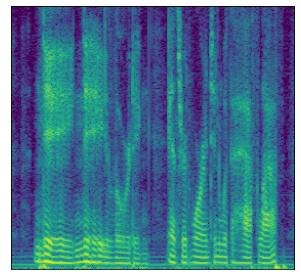

(257, 331) 5.355


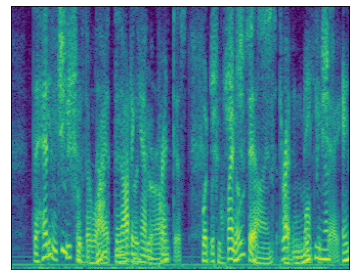

(257, 311) 5.025


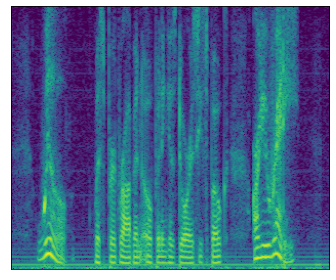

(257, 567) 9.125


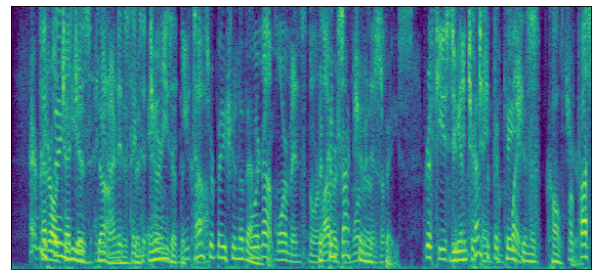

(257, 254) 4.12


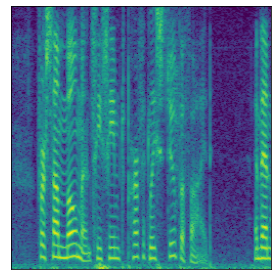

(257, 261) 4.23


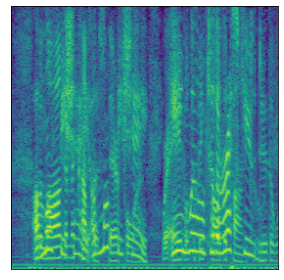

(257, 228) 3.705


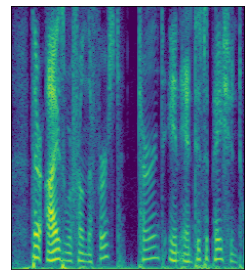

(257, 238) 3.87


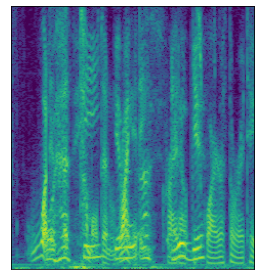

(257, 278) 4.51


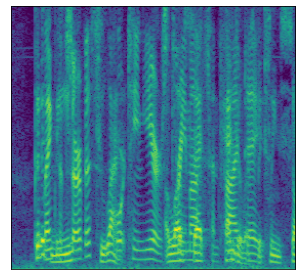

(257, 292) 4.73


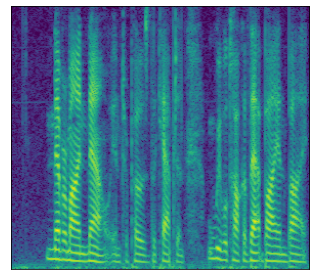

In [142]:

for subset in ['', 'baseline', 'ours', 'gt']:
    path = os.path.join('/home/jiangji/basic/codebase/demo-confusion/wavs/male2male', subset)
    
    stft = STFT(512, 128)

    plt.rcParams['figure.figsize'] = (20, 4)
    filelist = os.listdir(path)
    for file in filelist:
        if file.split('.')[-1] != 'wav':
            continue
        file_path = os.path.join(path, file)
        wav, fs = ta.load(file_path)
        mag, ph = stft(wav)
        mag = mag.numpy().squeeze()
        mag_pow_db = np.flip(librosa.amplitude_to_db(mag, ref=np.max), axis=0)
        mag_broad = cv2.resize(mag_pow_db, (mag_pow_db.shape[1], mag_pow_db.shape[0]))
        mag_show = mag_broad

        print(mag_show.shape, len(wav.squeeze())/8000)
        #mag_show = cv2.resize(mag_db, (mag_db.shape[0], mag_db.shape[1]), interpolation=cv2.INTER_AREA) 
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.imshow(mag_show)
        plt.savefig(os.path.join(path, file.split('.')[0]+'.png'), format='png')
        plt.show()

In [ ]:
stft = STFT(512, 128)
plt.rcParams['figure.figsize'] = (6,6)

wav, fs = ta.load('/home/jiangji/basic/codebase/demo-confusion/wavs/4446-2271-0012_1580-141083-0012_e0.wav')
mag, pha = stft(wav)
mag = mag.detach().cpu().numpy().squeeze()
y = librosa.amplitude_to_db(np.abs(mag), ref=np.max)

y = cv2.resize(y, (y.shape[0]*2, y.shape[1]), interpolation=cv2.INTER_AREA) 
plt.xticks([])
plt.yticks([])
plt.imshow(np.flip(y,axis=0))
plt.show()